In [14]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
# --- Load saved data ---
with open("power_data.pkl", "rb") as f:
    data = pickle.load(f)

df_pivot = data["df_pivot"]
ordered_devices = data["ordered_devices"]

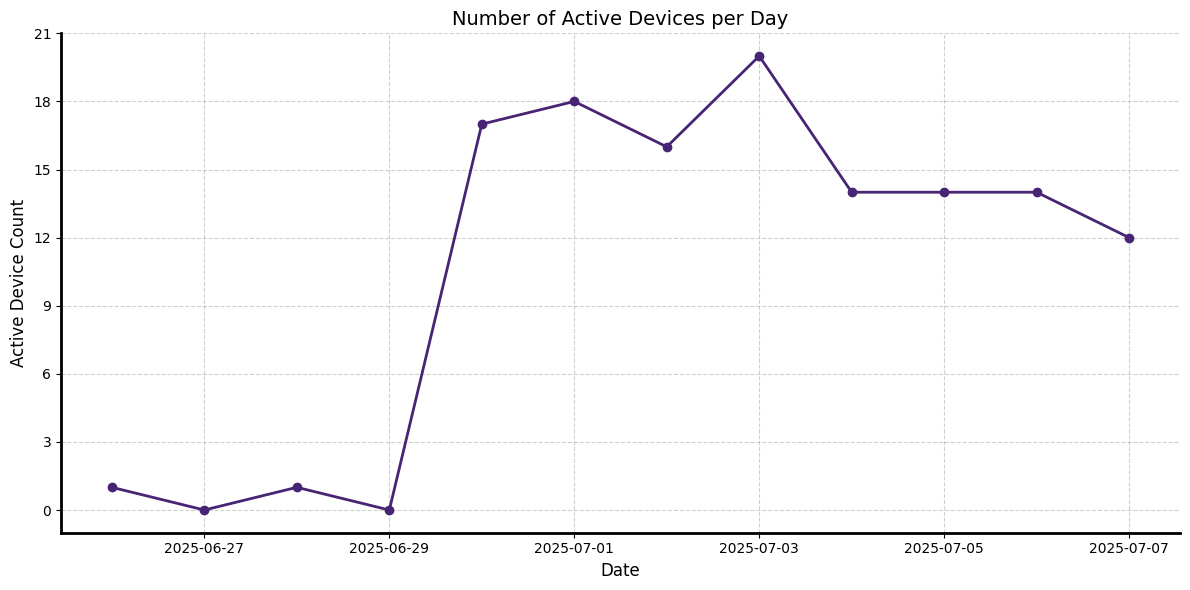

In [4]:
# Compute devices measure per day
# --- Drop Aggregate column ---
device_df = df_pivot.drop(columns=["Aggregate"])

# --- Resample by day and sum power ---
daily_power = device_df.resample("D").sum()

# --- Count active devices per day (sum > 0) ---
active_devices_per_day = (daily_power > 0).sum(axis=1)

# --- Plot ---
plt.figure(figsize=(12, 6))

# Choose a pleasant color from a colormap
color = cm.viridis(0.1)  # 0.0 to 1.0 range; adjust for preference

plt.plot(
    active_devices_per_day.index,
    active_devices_per_day.values,
    marker='o',
    linewidth=2,
    color=color
)

# Format plot aesthetics
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title("Number of Active Devices per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Active Device Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\brind\AppData\Local\Temp\ipykernel_66152\2308832879.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  device_hourly = (device_df.resample("H").mean() > 0)


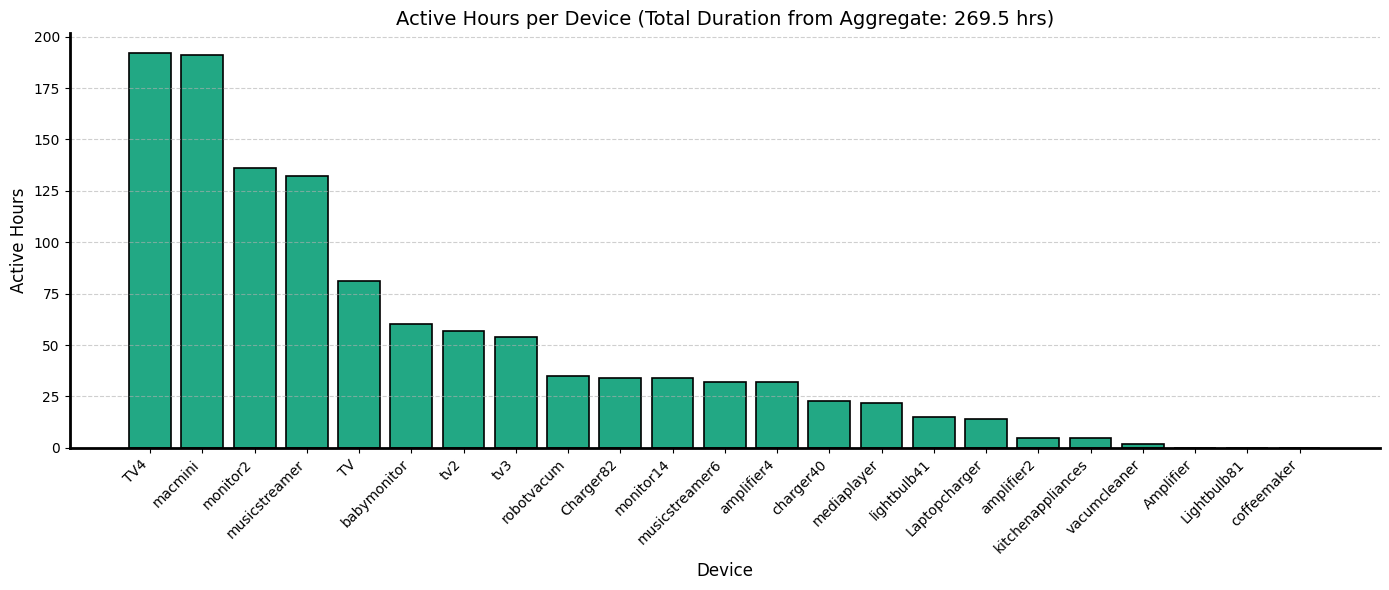

In [12]:

# --- Drop Aggregate column for counting active hours per device ---
device_df = df_pivot.drop(columns=["Aggregate"])

# --- Determine total recording time using the Aggregate signal ---
aggregate_signal = df_pivot["Aggregate"]
start_time = aggregate_signal.index.min()
end_time = aggregate_signal.index.max()
total_hours = round((end_time - start_time).total_seconds() / 3600, 1)

# --- Resample hourly and count non-zero entries ---
device_hourly = (device_df.resample("H").mean() > 0)
active_hours_per_device = device_hourly.sum()
active_hours_per_device = active_hours_per_device.sort_values(ascending=False)

# --- Plot ---
plt.figure(figsize=(14, 6))

color = cm.viridis(0.6)

plt.bar(
    active_hours_per_device.index,
    active_hours_per_device.values,
    color=color,
    edgecolor='black',
    linewidth=1.2
)

# --- Aesthetics ---
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title(f"Active Hours per Device (Total Duration from Aggregate: {total_hours} hrs)", fontsize=14)
plt.xlabel("Device", fontsize=12)
plt.ylabel("Active Hours", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\brind\AppData\Local\Temp\ipykernel_66152\2316283287.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = corr_ordered.applymap(format_annot)


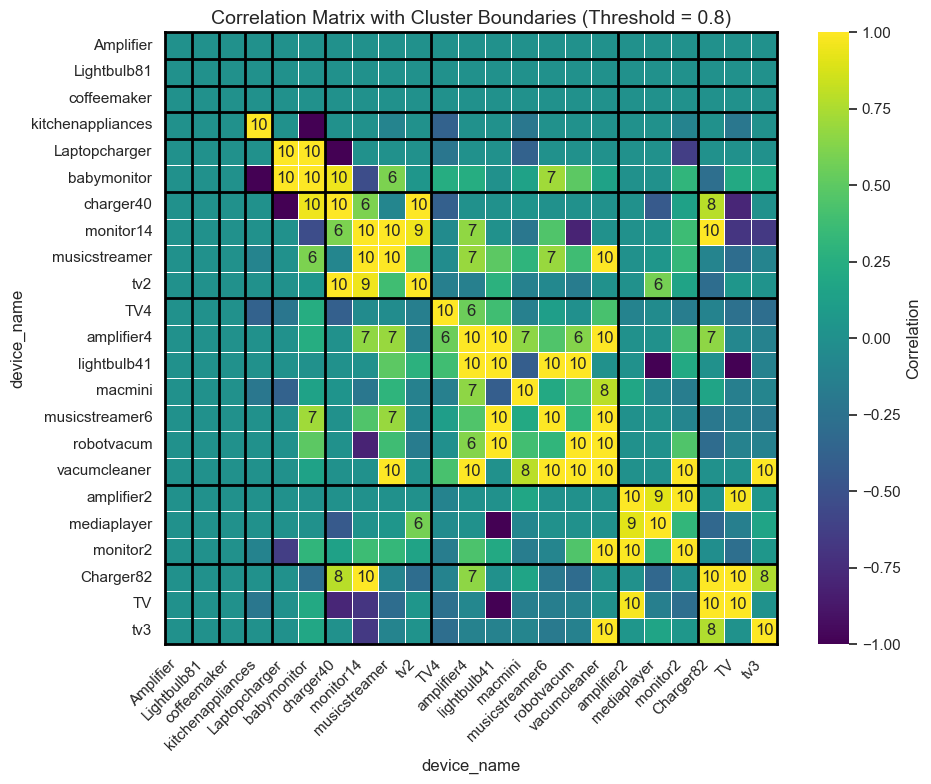

In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from scipy.spatial.distance import squareform

# --- Load data ---
with open("power_data.pkl", "rb") as f:
    data = pickle.load(f)

df_pivot = data["df_pivot"]
device_df = df_pivot.drop(columns=["Aggregate"])

# --- Resample to 1-minute bins ---
device_1min = device_df.resample("1min").mean().replace(0, np.nan)

# --- Compute correlation matrix ---
corr = device_1min.corr(method='pearson', min_periods=1).fillna(0)
corr_clipped = corr.clip(lower=-1, upper=1)

# --- Convert to distance matrix ---
distance = 1 - corr_clipped
distance = distance.clip(lower=0)
np.fill_diagonal(distance.values, 0)

# --- Hierarchical clustering ---
linkage_matrix = linkage(squareform(distance), method='average')

# --- Choose a threshold to define clusters ---
threshold = 0.8  # Adjust as needed
cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

# --- Build a DataFrame for ordering ---
cluster_df = pd.DataFrame({
    'device': corr.columns,
    'cluster': cluster_labels
}).sort_values(by=['cluster', 'device'])

ordered_labels = cluster_df['device'].tolist()
corr_ordered = corr.loc[ordered_labels, ordered_labels]

# --- Custom annotation formatting ---
def format_annot(val):
    if val > 0.95:
        return "10"
    elif val > 0.5:
        return str(int(round(val * 10)))
    else:
        return ""

annot_matrix = corr_ordered.applymap(format_annot)

# --- Plot heatmap ---
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr_ordered,
    cmap="viridis",
    annot=annot_matrix,
    fmt="",
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Correlation"}
)

# --- Add black outer border ---
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor("black")

# --- Add thick lines at cluster boundaries ---
cluster_sizes = cluster_df['cluster'].value_counts().sort_index().tolist()
boundaries = np.cumsum(cluster_sizes)

for b in boundaries[:-1]:  # skip final edge
    ax.axhline(b, color='black', linewidth=2)
    ax.axvline(b, color='black', linewidth=2)

# --- Final touches ---
plt.title(f"Correlation Matrix with Cluster Boundaries (Threshold = {threshold})", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
